In [21]:
import GPRutils
import vK2KGPR
import numpy as np
from importlib import reload

In [16]:
reload(GPRutils)

<module 'GPRutils' from '/home/fortino/DESworkspace/GPRutils.py'>

In [17]:
dataC = GPRutils.dataContainer()

In [18]:
dataC.load()

Exposure: 364215
Band: z
Number of objects: 110646


INFO: Query finished. [astroquery.utils.tap.core]
There were 10847 matches within 0.5 arcsec.


In [19]:
dataC.splitData()

In [22]:
GP = vK2KGPR.vonKarman2KernelGPR(dataC, printing=True, outDir=".")

In [1]:
import os

import getGaiaDR2 as gaia
import gnomonic as gn

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import astropy.table as tb
import astropy.coordinates as co
from astropy.time import Time
from scipy.spatial.ckdtree import cKDTree
from sklearn.model_selection import train_test_split

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
"""Choose an exposure that is definitely in zone 134."""
zoneDir = "/data3/garyb/tno/y6/zone134"
tile0 = "DES2203-4623_final.fits"
file0 = os.path.join(zoneDir, tile0)
tab0 = tb.Table.read(file0)
expNum = np.unique(tab0["EXPNUM"])[10]

In [3]:
"""
Find the approximate patch of sky (denoted by the center of the patch and
the width and height (except all DES exposures are the same size, so only the
center coordinate needs to be known)) in order to retrieve stars from the Gaia
catalog.
"""
pos_tab = tb.Table.read("../y6a1.exposures.positions.fits.gz", hdu=1)
pos_tab = pos_tab[pos_tab["expnum"] == expNum]
ra0 = pos_tab["ra"][0]
dec0 = pos_tab["dec"][0]
obs0 = pos_tab["mjd_mid"][0]

In [4]:
"""Find all tiles that our exposure is a part of."""
tiles_tab = tb.Table.read("../expnum_tile.fits.gz")
tiles = tiles_tab[tiles_tab["EXPNUM"] == expNum]["TILENAME"]

DES_tab = tab0.copy()
DES_tab.remove_rows(np.arange(len(DES_tab)))
for tile in tiles:
    try:
        tile = str(tile) + "_final.fits"
        file = os.path.join(zoneDir, tile)
        tab = tb.Table.read(file)
        tab = tab[tab["EXPNUM"] == expNum]
        DES_tab = tb.vstack([DES_tab, tab])
    except FileNotFoundError:
        print(f"File not found: {file}, continuing without it")
        continue
print(f"Exposure: {expNum}")
print(f"Band: {np.unique(DES_tab['BAND'])[0]}")
print(f"Number of objects: {len(DES_tab)}")

DES_obs = Time(obs0, format="mjd", scale="tcb")
DES_ra = np.array(DES_tab["NEW_RA"])*u.deg
DES_dec = np.array(DES_tab["NEW_DEC"])*u.deg
DES_err = np.array(DES_tab["ERRAWIN_WORLD"])*u.deg

Exposure: 364215
Band: z
Number of objects: 110646


In [56]:
"""Retrieve Gaia data."""
GAIA_tab = gaia.getGaiaCat(ra0, dec0, 2.5, 2.5)

GAIA_obs = Time("J2015.5", format="jyear_str", scale="tcb")
GAIA_ra = np.array(GAIA_tab["ra"])*u.deg - 360*u.deg
GAIA_dec = np.array(GAIA_tab["dec"])*u.deg
GAIA_pmra_cosdec = np.array(GAIA_tab["pmra"])*u.mas/u.yr
GAIA_pmdec = np.array(GAIA_tab["pmdec"])*u.mas/u.yr
GAIA_parallax = np.array(GAIA_tab["parallax"])*u.mas
GAIA_cov = np.array(GAIA_tab["cov"])
GAIA_cov = np.reshape(GAIA_cov, (GAIA_cov.shape[0], 5, 5))

INFO: Query finished. [astroquery.utils.tap.core]


In [98]:
GAIA_tab.info

<Table masked=True length=30894>
   name     dtype  shape   unit                              description                             n_bad
---------- ------- ----- -------- ------------------------------------------------------------------ -----
 source_id   int64                Unique source identifier (unique within a particular Data Release)     0
        ra float64            deg                                                    Right ascension     0
       dec float64            deg                                                        Declination     0
  parallax float64            mas                                                           Parallax     0
      pmra float64       mas / yr                         Proper motion in right ascension direction     0
     pmdec float64       mas / yr                             Proper motion in declination direction     0
      gmag float32            mag                                              G-band mean magnitude     0
    

In [57]:
"""Remap Gaia to the moment of DES exposure."""
dt = DES_obs - GAIA_obs
GAIA_ra += dt * GAIA_pmra_cosdec / np.cos(GAIA_dec)
GAIA_dec += dt * GAIA_pmdec

In [58]:
"""Match DES objects with Gaia counterparts based on how close together they are on the sky."""
X_DES = co.SkyCoord(DES_ra, DES_dec)
X_GAIA = co.SkyCoord(GAIA_ra, GAIA_dec)

idx, sep2d, dist3d = co.match_coordinates_sky(X_GAIA, X_DES)
tol = 0.5*u.arcsec
ind_GAIA = np.where(sep2d < tol)[0]
ind_DES = idx[ind_GAIA]

print(f"There were {ind_GAIA.size} matches within {tol}.")

There were 10847 matches within 0.5 arcsec.


In [59]:
"""Gnomonic projection for DES and GAIA stars."""
def gnomonicProjection(X, RA0=ra0, dec0=dec0, rot=0):
    pole = co.SkyCoord(RA0, dec0, unit='deg', frame='icrs')
    frame = pole.skyoffset_frame(rotation=co.Angle(rot, unit='deg'))

    s = X.transform_to(frame)

    # Get 3 components on unit sphere
    x = np.cos(s.lat.radian)*np.cos(s.lon.radian)
    y = np.cos(s.lat.radian)*np.sin(s.lon.radian)
    z = np.sin(s.lat.radian)
    out_x = y/x * (180. / np.pi)
    out_y = z/x * (180. / np.pi)
    return np.array([out_x, out_y]).T

X_gn_DES = gnomonicProjection(X_DES) * u.deg
X_gn_GAIA = gnomonicProjection(X_GAIA) * u.deg

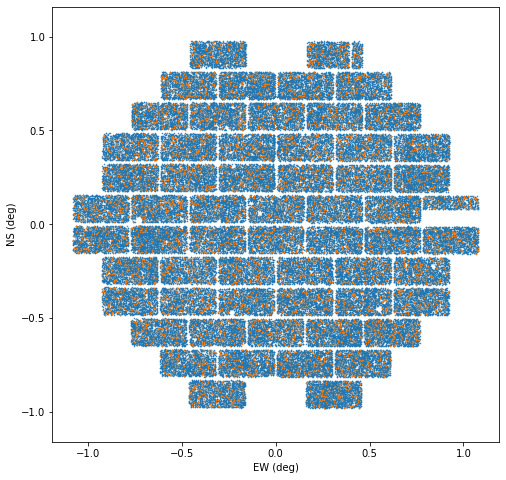

In [60]:
plt.figure(figsize=(8, 8))
plt.scatter(
    *X_gn_DES.T,
    marker=".", s=1)
plt.scatter(
    *X_gn_GAIA[ind_GAIA].T,
    marker=".", s=1)
plt.xlabel("EW (deg)")
plt.ylabel("NS (deg)")
plt.axis("equal")
plt.show()

In [89]:
X_tv = X_gn_DES[ind_DES]
Y_tv = X_gn_GAIA[ind_GAIA] - X_gn_DES[ind_DES]
E_tv_GAIA = GAIA_cov[ind_GAIA]
E_tv_DES = DES_err[ind_DES]

# XXX What is the best train size to use?
split = train_test_split(
    X_tv, Y_tv, E_tv_GAIA, E_tv_DES,
    train_size=0.80)
Xtrain, Xvalid = split[0], split[1]
Ytrain, Yvalid = split[2], split[3]
Etrain_GAIA, Evalid_GAIA = split[4], split[5]
Etrain_DES, Evalid_DES = split[6], split[7]

Xpred = np.delete(X_gn_DES, ind_DES, axis=0)
Epred_DES = np.delete(DES_err, ind_DES, axis=0)
# Should I be using the errors that the GP provides instead of
# E_pred_DES? These errors go into the plotting algorithms.

In [90]:
Xtrain.shape, Ytrain.shape, Etrain_GAIA.shape, Etrain_DES.shape

((8677, 2), (8677, 2), (8677, 5, 5), (8677,))

In [91]:
Xvalid.shape, Yvalid.shape, Evalid_GAIA.shape, Evalid_DES.shape

((2170, 2), (2170, 2), (2170, 5, 5), (2170,))

In [92]:
Xpred.shape, Epred_DES.shape

((99801, 2), (99801,))

In [102]:
GAIA_tab["error"]

3.272157441781326e-08
8.346396382951236e-08
9.795946012310053e-08
1.4195818876465094e-08
1.730124353187149e-08
4.5698004541210905e-08
2.9415399625472187e-08
1.6713286850528598e-07
3.2087423996245533e-07
2.4372255083458623e-08
1.0867614889918395e-07
